In this notebook, we will be taking a look at the interpretability aspects of the adversarial examples that we created in [this notebook](https://github.com/dipanjanS/adversarial-learning-robustness/blob/main/tutorials/attacks/02_1_targeted_pgd.ipynb). Specifically, we will be using [Grad-CAM](https://arxiv.org/abs/1610.02391) to visualize the class activation maps of the pre-trained networks to understand what information is being used by these networks to make inference. We will also take a look at the feature maps that come out after applying a learned kernel from a pre-trained network to our input image.  

*For the Grad-CAM part, we will be using code from [this PyImageSearch blog post](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/).* 

In [1]:
!wget -q https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-gradcam/keras-grad-cam.zip
!unzip -qq keras-grad-cam.zip
%cd keras-grad-cam

/content/keras-grad-cam


## Initial Setup

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
# Other imports
from pyimagesearch.gradcam import GradCAM
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

Let's now gather two test images to perform off-the-shelf image classification with a ResNet50 pre-trained on the ImageNet dataset. One of these two images is adversarially perturbed (refer to [this notebook](https://github.com/dipanjanS/adversarial-learning-robustness/blob/main/tutorials/attacks/02_1_targeted_pgd.ipynb)) while another one is not. 

In [4]:
# First one is normal and the second one is adversarially perturbed
!wget -q https://i.ibb.co/YhL00L7/Large-White.jpg
!wget -q https://i.ibb.co/4RHsJQT/adversarial.png

## Visual Inspection of the Images

In [5]:
def show_image(image_path):
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.show()

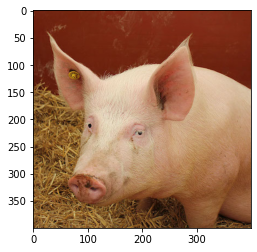

In [6]:
# Normal image
show_image("Large-White.jpg")

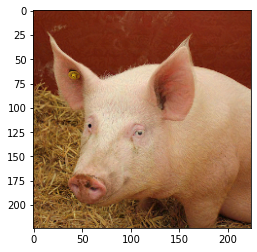

In [7]:
# Adversarially perturbed image
show_image("adversarial.png")

As we can see the two images are visually identical to our eyes.

## Running Grad-CAM Inspection

In [8]:
# Load the pre-trained ResNet50 model
model = ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 0s 0us/step


Let's now create a few utility functions for visualizing the class activation maps based on the network predictions. Majority of the code has been referred from the aforementioned PyImageSearch blog post. 

### Utility Functions

In [9]:
def preprocess_image(image_path):
    original = plt.imread(image_path)
    if np.max(original) <= 1:
        original_cp = original.copy()
        original_cp *= 255
        original = original_cp.astype(np.uint8)

    resized = cv2.resize(original, (224, 224))
    preprocessed = np.expand_dims(resized, axis=0)
    preprocessed = imagenet_utils.preprocess_input(preprocessed)

    return original, preprocessed

def run_gradcam(image_path, model):
    original, preprocessed = preprocess_image(image_path)

    preds = model.predict(preprocessed)
    i = np.argmax(preds[0])
    decoded = imagenet_utils.decode_predictions(preds)
    (id, label, prob) = decoded[0][0]
    label = "{}: {:.2f}%".format(label, prob * 100)
    print("[INFO] {}".format(label))

    cam = GradCAM(model, i)
    heatmap = cam.compute_heatmap(preprocessed)
    heatmap = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
    (heatmap, output) = cam.overlay_heatmap(heatmap, original, alpha=0.5)

    cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
    cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	    0.5, (255, 255, 255), 2)

    output = np.vstack([original, heatmap, output])
    output = imutils.resize(output, height=700)
    plt.figure(figsize=(12, 12))
    plt.imshow(output)
    plt.show()

40960/35363 [==================================] - 0s 0us/step
[INFO] hog: 99.97%


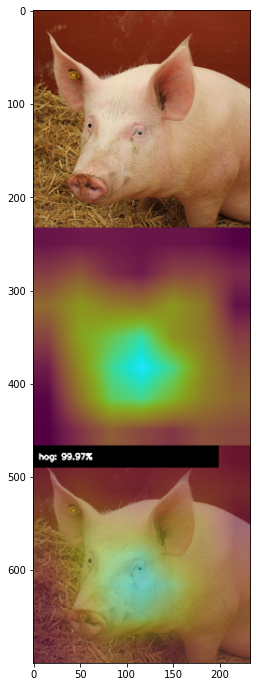

In [10]:
# Let's run Grad-CAM on the predictions made on the normal image
run_gradcam("Large-White.jpg", model)

Looks like our pre-trained network is picking up on the right attributes like face shape of the pig in order to arrive at the prediction (which is correct). Let's now repeat this for the adversarially perturbed image. 

**Note** the adversarially perturbed image was generated using targeted attack where the target class was Lakeland Terrier. 

[INFO] Lakeland_terrier: 6.85%


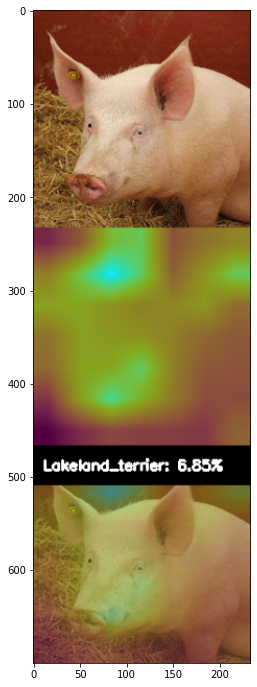

In [11]:
run_gradcam("adversarial.png", model)

From the class activation map, it's quite not clear what information is being picked up by our pre-trained network in order to make the inference. Also, it's important to note that the adversarial perturbation was created in a way such that the visual "hog"-ness of the original image is maintained and at the same the pre-trained network can get fooled to make the desired prediction (Lakeland Terrier in this case). So, methods like Grad-CAM may not give us the entire picture of what might be going wrong inside the network. 

Let's now switch to the visualization of the feature maps that come out of learned kernels of pre-trained networks. Some of the code is referred from [this Machine Learning Mastery blog post](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/).

## Inspecting the Feature Maps of Learned Kernels

First let's inspect the shapes of a few intermediate convolution layers of ResNet50.

In [56]:
conv_ids = []
for i in range(len(model.layers)):
    if i == 20:
        break
    layer = model.layers[i]
    if "conv" not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)
    conv_ids.append(i)

1 conv1_pad (None, 230, 230, 3)
2 conv1_conv (None, 112, 112, 64)
3 conv1_bn (None, 112, 112, 64)
4 conv1_relu (None, 112, 112, 64)
7 conv2_block1_1_conv (None, 56, 56, 64)
8 conv2_block1_1_bn (None, 56, 56, 64)
9 conv2_block1_1_relu (None, 56, 56, 64)
10 conv2_block1_2_conv (None, 56, 56, 64)
11 conv2_block1_2_bn (None, 56, 56, 64)
12 conv2_block1_2_relu (None, 56, 56, 64)
13 conv2_block1_0_conv (None, 56, 56, 256)
14 conv2_block1_3_conv (None, 56, 56, 256)
15 conv2_block1_0_bn (None, 56, 56, 256)
16 conv2_block1_3_bn (None, 56, 56, 256)
17 conv2_block1_add (None, 56, 56, 256)
18 conv2_block1_out (None, 56, 56, 256)
19 conv2_block2_1_conv (None, 56, 56, 64)


We can now create a sub-model utilizing any of the above layers as the output layer of that sub-model. But we won't be able to plot all the channels in the intermediate layers at one go. Instead, we will consider them individually and plot them. 

In [57]:
def show_feature_maps(image_path, interm_layer):
    # Create our sub-model
    interm_model = tf.keras.Model(inputs=model.inputs, 
                                  outputs=model.layers[interm_layer].output)
    
    # Preprocess the input image
    _, preprocessed = preprocess_image(image_path)

    # Get the feature map from the current intermediate layer
    feature_map = interm_model.predict(preprocessed)

    # Plot the feature map individually w.r.t the channels
    square = 8
    ix = 1
    plt.figure(figsize=(10, 10))
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_map[0, :, :, ix-1], cmap='gray')
            ix += 1
    plt.show()

### Setting 1: Normal Image, 4th `conv_bn`

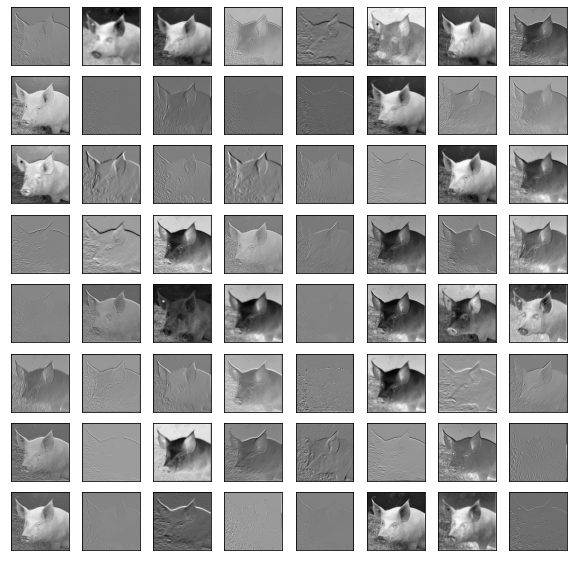

In [58]:
show_feature_maps("Large-White.jpg", 3)

### Setting 2: Normal Image, 9th `conv2_block1_1_bn`

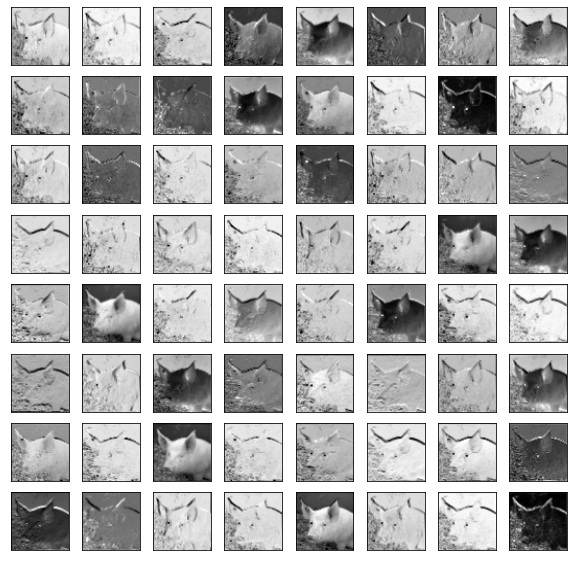

In [59]:
show_feature_maps("Large-White.jpg", 8)

Looks like the feature maps are visually coherent with the discriminative signals of our input image. Let's now repeat these same settings for the adversarially perturbed image. 

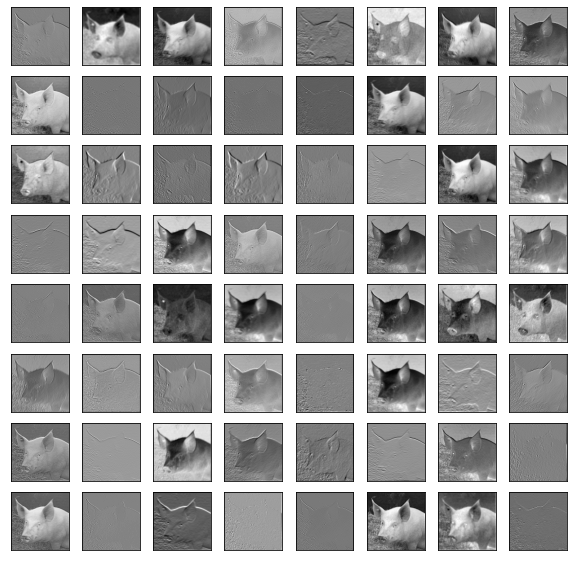

In [60]:
show_feature_maps("adversarial.png", 3)

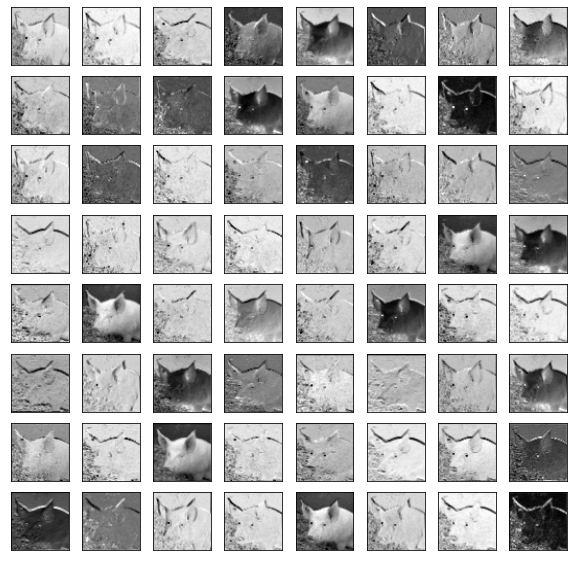

In [61]:
show_feature_maps("adversarial.png", 8)

It's hard to distinguish the differences in between the features maps obtained from two different images we tested the network on. This may emphasize the difficulty interpreting adversarial examples to probe into our network's failures. To this end, we refer the interested reader to [this CVPR (2020) workshop on Adversarial Machine Learning](https://www.youtube.com/watch?v=us-iTfiwsRI&feature=youtu.be) where eminent researchers working in the field shed light on many related important areas.  